## Delong Test for Any Pair of Models 

For all models, we train them with training data and test them with validation data. 

In this notebook, we need to conduct delong test to obtain all p values for any pair of models.

In [1]:
import os 
import numpy as np 
import pandas as pd 

def get_data( csv_file ):
    data = pd.read_csv( csv_file ) 
    vars = data.columns
    xs, ys = data[ vars[2:-1] ], data[ [vars[-1]] ]
    return xs, ys 

train_x, train_y = get_data( "train.csv" )
val_x, val_y = get_data( "val.csv" )
train_y, val_y = np.array(train_y).reshape(-1), np.array(val_y).reshape(-1)

In [2]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
import sklearn.metrics as metrics

# modify the RGB values for each model
model_list = [ "LogisticRegression", "RandomForest", "Xgboost", "Lightgbm", "DecisionTree", "SVM", "KNN" ] 

preds = [  ]

lr = LogisticRegression( penalty='l2', C=0.12, solver='newton-cg', max_iter=100 )
lr.fit( train_x, train_y )
preds.append( lr.predict(val_x) )

rf = RandomForestClassifier( criterion='log_loss', n_estimators=280, max_features='log2', max_depth=6 )
rf.fit( train_x, train_y )
preds.append( rf.predict(val_x) )

xgb = XGBClassifier( eta=0.7, max_depth=7, min_child_weight=3 )
xgb.fit( train_x, train_y )
preds.append( xgb.predict(val_x) )

lgb = LGBMClassifier(n_estimators=500, verbose=-1)
lgb.fit( train_x, train_y )
preds.append( lgb.predict(val_x) )

dt = tree.DecisionTreeClassifier()
dt.fit( train_x, train_y )
preds.append( dt.predict(val_x) )

knn = KNeighborsClassifier( 5 )
knn.fit( train_x.values, train_y )
print(val_x.shape[0], val_x.shape)
test_samples = [ val_x.iloc[i] for i in range( val_x.values.shape[0] ) ]
preds.append( knn.predict(test_samples) )

svm = SVC( probability=True )
svm.fit( train_x, train_y )
preds.append( svm.predict(val_x) )  


153 (153, 13)


### Delong Test

In [3]:
# import dependency 
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [4]:
# refer: https://github.com/yandexdataschool/roc_comparison/blob/master/compare_auc_delong_xu.py
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N)
    T2[J] = T + 1
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):

    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

def calc_pvalue(aucs, sigma):
    """
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       pvalue
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    log10_p = np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)  # Computes log(10) of p-values
    return 10 ** log10_p


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)



In [5]:
res_table = dict()
leng = len(preds)
for i in range( leng ):
    ps = []
    for j in range( leng ):
        ps.append( delong_roc_test( val_y, preds[i], preds[j] )[0,0] )
    res_table[ model_list[i] ] = ps 
    print(ps) 

df = pd.DataFrame( data = res_table ) 
df.rename( index={ i:model_list[i] for i in range(leng) }, inplace=True ) 
df.to_csv( "delong_test.csv" )


[nan, 0.6524262011194353, 0.7707649051314713, 0.15680411310894973, 0.0043456178559930555, 0.003857273999549423, 6.0646093375179925e-05]
[0.6524262011194353, nan, 1.0000000000000002, 0.20000529271911419, 0.012765672393029472, 0.008315173053598057, 0.0005066676975067232]
[0.7707649051314713, 1.0000000000000002, nan, 0.15192166648359082, 0.003855418017806997, 0.01192524506603446, 0.0021891005846535966]
[0.15680411310894973, 0.20000529271911419, 0.15192166648359082, nan, 0.08256885207503911, 0.09392648502789555, 0.02929207672441371]
[0.0043456178559930555, 0.012765672393029472, 0.003855418017806997, 0.08256885207503911, nan, 0.7036536324246176, 0.3507440163485974]
[0.003857273999549423, 0.008315173053598057, 0.01192524506603446, 0.09392648502789555, 0.7036536324246176, nan, 0.5799430268678155]
[6.0646093375179925e-05, 0.0005066676975067232, 0.0021891005846535966, 0.02929207672441371, 0.3507440163485974, 0.5799430268678155, nan]


#### a simple visualization p table

Text(0.5, 0, 'LR    RF    Xgb    Lgb    DT    SVM    KNN')

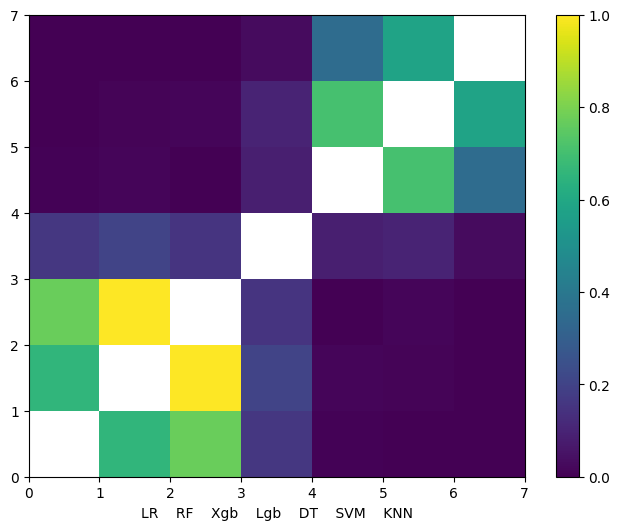

In [6]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots( 1,1, figsize=(8,6) )
tmp = ax.pcolormesh( df, cmap = "viridis", vmin=0, vmax=1 )
fig.colorbar( tmp, ax=ax )
ax.set_xlabel( "    ".join([ "LR", "RF", "Xgb", "Lgb", "DT", "SVM", "KNN" ]) ) 